In [77]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from itertools import combinations
from collections import Counter

### Sample dos dados

In [78]:
import numpy as np

df2 = pd.read_csv("dishes_data_filtered.csv")

unknown_df = df2[df2['cuisine'] == 'Unknown']
unknown_df.to_csv("dishes_data_with_unknown_cuisine.csv", index=False)

known_df = df2[df2['cuisine'] != 'Unknown']

sample_known = known_df.sample(frac=0.4, random_state=42)
sample_unknown = unknown_df.sample(n=(len(sample_known)//10), random_state=42)

balanced_sample = pd.concat([sample_unknown, sample_known])

df = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [79]:
df.info()
df.describe()
df['cuisine'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1010 non-null   object 
 1   recipeName          1010 non-null   object 
 2   rating              1010 non-null   int64  
 3   totalTimeInSeconds  1010 non-null   float64
 4   course              1010 non-null   object 
 5   cuisine             1010 non-null   object 
 6   ingredients         1010 non-null   object 
 7   dish                1010 non-null   object 
 8   timeMins            1010 non-null   float64
 9   ingred_count        1010 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 79.0+ KB


cuisine
Asian                   188
Barbecue                124
American                112
Italian                 110
Unknown                  91
Mexican                  75
Spanish                  70
Kid-Friendly             50
French                   46
Cajun & Creole           34
Indian                   24
Southwestern             13
Greek                    11
Southern & Soul Food     10
Japanese                 10
Thai                      9
Chinese                   8
German                    6
Mediterranean             6
Hawaiian                  3
Cuban                     3
Irish                     2
Moroccan                  2
Swedish                   1
Hungarian                 1
Portuguese                1
Name: count, dtype: int64

### Identificando as 10 culinárias melhor e pior avaliadas

In [81]:
df_analise = df

df_exploded = df_analise.explode("cuisine")
cuisine_counts = df_analise["cuisine"].value_counts()

print("\nNúmero de receitas por culinária:")
print(cuisine_counts)


Número de receitas por culinária:
cuisine
Asian                   188
Barbecue                124
American                112
Italian                 110
Unknown                  91
Mexican                  75
Spanish                  70
Kid-Friendly             50
French                   46
Cajun & Creole           34
Indian                   24
Southwestern             13
Greek                    11
Southern & Soul Food     10
Japanese                 10
Thai                      9
Chinese                   8
German                    6
Mediterranean             6
Hawaiian                  3
Cuban                     3
Irish                     2
Moroccan                  2
Swedish                   1
Hungarian                 1
Portuguese                1
Name: count, dtype: int64


In [ ]:
cuisine_ratings_high = df_exploded.groupby("cuisine")["rating"].mean().sort_values(ascending=False)
cuisine_ratings_low = df_exploded.groupby("cuisine")["rating"].mean().sort_values(ascending=True)

print("\n10 culinárias melhor avaliadas:")
print(cuisine_ratings_high.head(10))
print("\n10 culinárias pior avaliadas:")
print(cuisine_ratings_low.head(10))


10 culinárias mais bem avaliadas:
cuisine
Portuguese              5.000000
Cuban                   4.333333
German                  4.166667
American                4.151786
Southern & Soul Food    4.100000
Kid-Friendly            4.020000
Hungarian               4.000000
Swedish                 4.000000
Irish                   4.000000
Italian                 3.881818
Name: rating, dtype: float64

10 culinárias mais mal avaliadas:
cuisine
Chinese           2.625000
Moroccan          3.500000
Mediterranean     3.500000
Spanish           3.557143
Indian            3.625000
Hawaiian          3.666667
Cajun & Creole    3.676471
Japanese          3.700000
Asian             3.712766
French            3.717391
Name: rating, dtype: float64


### Análise dos ingredientes mais utilizados em receitas com notas altas e baixas

In [ ]:
df_analise["ingredients"] = df_analise["ingredients"].str.strip("[]").str.replace("'", "").str.split(", ")

high_rating_threshold = 4
low_rating_threshold = 2

high_rating_recipes = df_analise[df_analise["rating"] >= high_rating_threshold]["ingredients"]
low_rating_recipes = df_analise[df_analise["rating"] <= low_rating_threshold]["ingredients"]

high_rating_ingredients = Counter([item for sublist in high_rating_recipes for item in sublist])
low_rating_ingredients = Counter([item for sublist in low_rating_recipes for item in sublist])

top_high_rating_ingredients = high_rating_ingredients.most_common(10)
top_low_rating_ingredients = low_rating_ingredients.most_common(10)

print("Nº de receitas bem avaliadas(nota>=4):")
print(len(high_rating_recipes))
print("\nNº de  receitas mal avaliadas(nota<=2):")
print(len(low_rating_recipes))

print("\n10 ingredientes mais utilizados em receitas bem avaliadas:")
print(top_high_rating_ingredients)
print("\n10 ingredientes mais utilizados em receitas mal avaliadas:")
print(top_low_rating_ingredients)

Nº de receitas bem avaliadas:
730

Nº de  receitas mal avaliadas:
10

Top 10 ingredientes em receitas bem avaliadas:
[('salt', 296), ('garlic', 180), ('onions', 165), ('olive oil', 150), ('water', 121), ('pepper', 93), ('butter', 87), ('soy sauce', 87), ('garlic cloves', 85), ('eggs', 81)]

Top 10 ingredientes em receitas mal avaliadas:
[('salt', 9), ('onions', 5), ('water', 4), ('garlic', 4), ('black pepper', 3), ('olive oil', 3), ('scallions', 3), ('soy sauce', 3), ('sesame oil', 3), ('ginger', 3)]


### Construindo a rede com NetworkX

In [404]:
G = nx.Graph()

# Adicionar nós
for _, row in df.iterrows():
    G.add_node(row['id'], cuisine=row['cuisine'], ingredients=row['ingredients'], rating=row['rating'], time=row['timeMins'], ingred_count=row['ingred_count'])

# Adicionar arestas baseadas na similaridade de ingredientes
for dish1, dish2 in combinations(df['id'], 2):
    # Remover colchetes e espaços antes de dividir
    ingredients1 = set(df.loc[df['id'] == dish1, 'ingredients'].values[0].replace('[', '').replace(']', '').replace(' ', '').split(','))
    ingredients2 = set(df.loc[df['id'] == dish2, 'ingredients'].values[0].replace('[', '').replace(']', '').replace(' ', '').split(','))
    
    jaccard_sim = len(ingredients1 & ingredients2) / len(ingredients1 | ingredients2)

    if jaccard_sim > 0.2:  # Threshold para criar aresta
        G.add_edge(dish1, dish2, weight=jaccard_sim)

A similaridade de Jaccard é uma medida de similaridade entre dois conjuntos, calculada pela fórmula:
J(A,B)= 
∣A∪B∣ /
∣A∩B∣
​

onde A e B são os conjuntos de ingredientes dos pratos dish1 e dish2, respectivamente.
ingredients1 & ingredients2: Calcula a interseção dos dois conjuntos de ingredientes (ou seja, os ingredientes que ambos os pratos têm em comum).
ingredients1 | ingredients2: Calcula a união dos dois conjuntos de ingredientes (todos os ingredientes distintos de ambos os pratos).
jaccard_sim será um valor entre 0 e 1, onde valores mais altos indicam maior similaridade entre os pratos.
Criação das Arestas:

Se a similaridade de Jaccard (jaccard_sim) for maior que um threshold (no caso, 0.3), o código cria uma aresta entre os dois pratos usando G.add_edge(dish1, dish2, weight=jaccard_sim).
A aresta tem um peso que corresponde ao valor da similaridade de Jaccard.
Isso significa que dois pratos com ingredientes mais semelhantes terão uma aresta mais forte (peso maior), enquanto pratos com ingredientes diferentes terão uma aresta fraca (peso baixo).
Resultado: O grafo agora contém arestas entre os pratos que possuem uma quantidade significativa de ingredientes em comum. A força dessa relação é representada pelo peso das arestas.

In [405]:
print("Rede criada com", G.number_of_nodes(), "nós e", G.number_of_edges(), "arestas.")
print(f'Atributo dos nós (sample): {list(G.nodes(data=True))[:5]}')
print(f'Atributo das arestas (sample): {list(G.edges(data=True))[:5]}')

Rede criada com 1010 nós e 2483 arestas.
Atributo dos nós (sample): [('Portuguese-Duck-Risotto-513395', {'cuisine': 'Portuguese', 'ingredients': '[olive oil, duck drumsticks, ground black pepper, kosher salt, homemade chicken stock, spanish chorizo, boneless moulard duck breast, yellow onion, carnaroli rice, dry white wine, serrano ham, fresh orange juice, unsalted butter, parsley leaves, orange zest]', 'rating': 5, 'time': 165.0, 'ingred_count': 15}), ('Puerto-Nuevo_style-Lobster-Tacos-Epicurious', {'cuisine': 'Mexican', 'ingredients': '[lobster, butter, lime, rice, salsa, flour tortillas, lime wedges]', 'rating': 4, 'time': 45.0, 'ingred_count': 7}), ('Spanish-Chicken-Chorizo-Paella-1216629', {'cuisine': 'Spanish', 'ingredients': '[chicken breasts, sea salt, ground black pepper, olive oil, onions, chorizo sausage, garlic cloves, red bell pepper, orange bell pepper, medium tomatoes, long grain white rice, smoked paprika, saffron threads, red pepper flakes, chile powder, chicken broth,

### Visualizando a rede

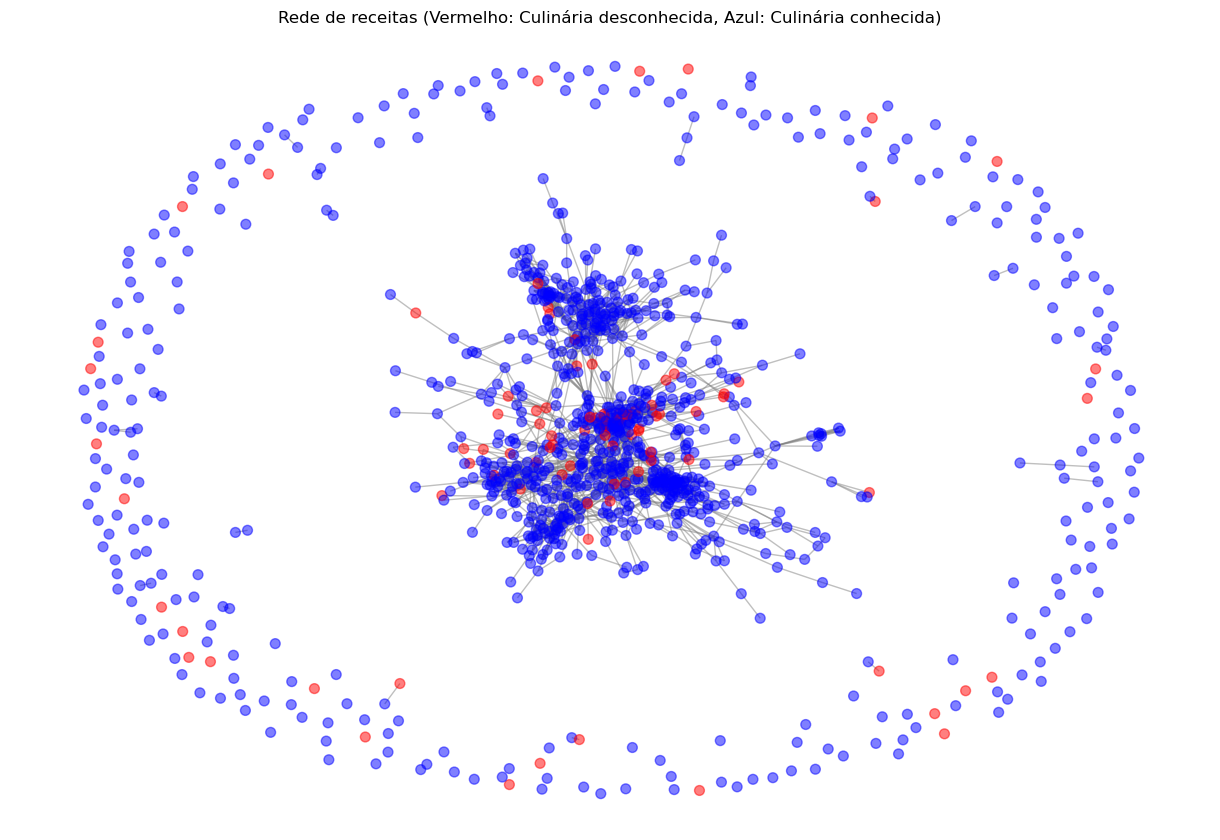

In [406]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

node_colors = ['red' if G.nodes[n]['cuisine'] == "Unknown" else 'blue' for n in G.nodes]

nx.draw(G, pos, with_labels=False, node_size=50, node_color=node_colors, edge_color='gray', alpha=0.5)

plt.title("Rede de receitas (Vermelho: Culinária desconhecida, Azul: Culinária conhecida)")
plt.show()

### Cálculo das features

In [407]:
features = []

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    if not neighbors:
        continue

    weighted_sum_rating = 0
    weighted_sum_time = 0
    weighted_sum_ingred_count = 0
    total_weight = 0

    for neighbor in neighbors:
        weight = G[node][neighbor]['weight']
        
        if pd.notna(G.nodes[neighbor]['rating']):
            weighted_sum_rating += G.nodes[neighbor]['rating'] * weight
        if pd.notna(G.nodes[neighbor]['time']):
            weighted_sum_time += G.nodes[neighbor]['time'] * weight
        if pd.notna(G.nodes[neighbor]['ingred_count']):
            weighted_sum_ingred_count += G.nodes[neighbor]['ingred_count'] * weight
        total_weight += weight

    avg_rating = weighted_sum_rating / total_weight if total_weight > 0 else 0
    avg_time = weighted_sum_time / total_weight if total_weight > 0 else 0
    avg_ingred_count = weighted_sum_ingred_count / total_weight if total_weight > 0 else 0
    num_neighbors = len(neighbors)

    clustering_coeff = nx.clustering(G, node, weight='weight')  # Coeficiente de agrupamento
    degree_centrality = nx.degree_centrality(G)[node]  # Centralidade de grau
    closeness_centrality = nx.closeness_centrality(G)[node]  # Centralidade de proximidade
    betweenness_centrality = nx.betweenness_centrality(G)[node]  # Centralidade de intermediação
    
    cuisine = G.nodes[node]['cuisine']
    features.append([
        node,
        avg_rating, 
        avg_time, 
        avg_ingred_count, 
        num_neighbors, 
        clustering_coeff, 
        degree_centrality, 
        closeness_centrality, 
        betweenness_centrality, 
        cuisine])


In [408]:
print("Nós ignorados por não estarem conectados", (G.number_of_nodes())-len(features))

Nós ignorados por não estarem conectados 260


In [409]:
df_features = pd.DataFrame(features, columns=[
    'node', 
    'avg_rating', 
    'avg_time', 
    'avg_ingred_count', 
    'num_neighbors', 
    'clustering_coeff', 
    'degree_centrality', 
    'closeness_centrality', 
    'betweenness_centrality',
    'cuisine'])

# Salvar o dataframe antes da previsão
df_features.to_csv("data_before_prediction.csv", index=False)

In [410]:
df_features.loc[df_features['cuisine'] == "Unknown"]

,node,avg_rating,avg_time,avg_ingred_count,num_neighbors,clustering_coeff,degree_centrality,closeness_centrality,betweenness_centrality,cuisine
38,Hill-Country-Peach-and-Strawberry-Cobbler-779297,4.160741,46.016945,8.834965,18,0.140579,0.017839,0.155248,0.001277,Unknown
43,Sweet-Chile-Hot-Wings-597020,3.920520,141.589595,7.238439,4,0.138176,0.003964,0.156519,0.001893,Unknown
44,Kale-Caesar-Salad-With-Pomegranate-1036746,4.000000,70.222739,8.186835,4,0.037376,0.003964,0.162563,0.003867,Unknown
58,Charred-Blood-Orange-Tart-1349660,4.228605,57.243306,10.720240,8,0.108677,0.007929,0.153048,0.000083,Unknown
72,Minnesota-style-Manhattan-Clam-Chowder-1359628,4.000000,129.051095,19.357664,3,0.168334,0.002973,0.147679,0.000011,Unknown
...,...,...,...,...,...,...,...,...,...,...
692,Fluffy-Whole-Wheat-Pancakes-1237360,4.391982,55.211581,9.469933,4,0.284885,0.003964,0.127875,0.000009,Unknown
693,Copycat-Cheesecake-Factory-Original-Cheesecake...,4.000000,42.000000,7.000000,1,0.000000,0.000991,0.107276,0.000000,Unknown
704,Pressed-Italian-Sandwiches-1100833,3.333142,50.828546,9.304556,6,0.109637,0.005946,0.167779,0.001358,Unknown
722,Chocolate-Chip-Cream-Cheese-Cookie-Bars-1269102,4.553492,43.404552,8.749118,5,0.232018,0.004955,0.136407,0.000006,Unknown


In [411]:
labeled_data = df_features[df_features['cuisine'] != "Unknown"]
if not labeled_data.empty:
    X = labeled_data.drop(columns=['cuisine', 'node'])
    y = labeled_data["cuisine"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

    unknown_nodes = df_features[df_features['cuisine'] == "Unknown"].drop(columns=['cuisine'])
    if not unknown_nodes.empty:
        predictions = clf.predict(unknown_nodes.drop(columns=['node']))
        df_features.loc[df_features['cuisine'] == "Unknown", 'predicted_cuisine'] = predictions

    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': clf.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    df_features.to_csv("data_after_prediction.csv", index=False)

Accuracy: 0.5217391304347826
                precision    recall  f1-score   support

      American       0.22      0.29      0.25         7
         Asian       0.44      0.58      0.50        12
      Barbecue       0.67      0.86      0.75         7
Cajun & Creole       0.50      0.50      0.50         4
       Chinese       0.00      0.00      0.00         1
        French       0.00      0.00      0.00         2
         Greek       1.00      0.50      0.67         2
        Indian       0.00      0.00      0.00         5
       Italian       0.75      0.33      0.46         9
  Kid-Friendly       1.00      0.33      0.50         3
       Mexican       0.50      0.67      0.57         3
  Southwestern       0.00      0.00      0.00         1
       Spanish       0.71      0.92      0.80        13

      accuracy                           0.52        69
     macro avg       0.44      0.38      0.38        69
  weighted avg       0.52      0.52      0.49        69



c:\Users\meika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\meika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\meika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [412]:
df_features[df_features['cuisine'] == "Unknown"].head()

,node,avg_rating,avg_time,avg_ingred_count,num_neighbors,clustering_coeff,degree_centrality,closeness_centrality,betweenness_centrality,cuisine,predicted_cuisine
38,Hill-Country-Peach-and-Strawberry-Cobbler-779297,4.160741,46.016945,8.834965,18,0.140579,0.017839,0.155248,0.001277,Unknown,French
43,Sweet-Chile-Hot-Wings-597020,3.920520,141.589595,7.238439,4,0.138176,0.003964,0.156519,0.001893,Unknown,French
44,Kale-Caesar-Salad-With-Pomegranate-1036746,4.000000,70.222739,8.186835,4,0.037376,0.003964,0.162563,0.003867,Unknown,Barbecue
58,Charred-Blood-Orange-Tart-1349660,4.228605,57.243306,10.720240,8,0.108677,0.007929,0.153048,0.000083,Unknown,Italian
72,Minnesota-style-Manhattan-Clam-Chowder-1359628,4.000000,129.051095,19.357664,3,0.168334,0.002973,0.147679,0.000011,Unknown,Cajun & Creole


C:\Users\meika\AppData\Local\Temp\ipykernel_388\2954483844.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette="viridis")


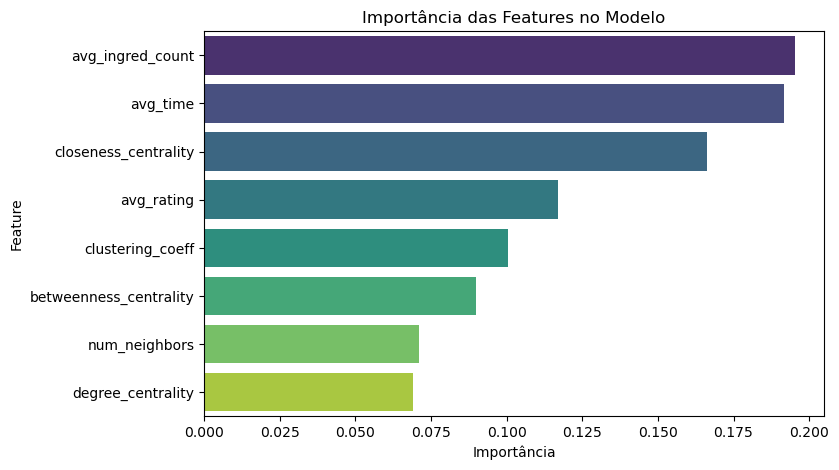

In [413]:

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette="viridis")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Importância das Features no Modelo")
plt.show()

In [414]:
print("Top 10 features mais importantes:")
print(feature_importances.head(10))

Top 10 features mais importantes:
                  Feature  Importance
2        avg_ingred_count    0.195146
1                avg_time    0.191745
6    closeness_centrality    0.166175
0              avg_rating    0.116827
4        clustering_coeff    0.100304
7  betweenness_centrality    0.089830
3           num_neighbors    0.070904
5       degree_centrality    0.069068
